In [142]:
import pickle

import jax.nn
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import time

import optax
import tqdm.notebook as tqdm

In [133]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import ToyData1
from experiments.src.model import BNNRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# %matplotlib inline
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [135]:
DEVICE = "gpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 2
BNN_SIZE = [64, 128, 128, 128, 64]

In [136]:
data = ToyData1(D_X=D_X, train_size=100)

In [137]:
bnn = BNNRegressor(
    nonlin=jax.nn.silu,
    D_X=D_X,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    prior_scale=10,
    prior_type='xavier',
)

In [138]:
bnn.get_weight_dim()

998

## Experiment

In [193]:
HOURS = 60 * 60
MAX_TIME = 4 * HOURS
NUM_CHAINS = 4
MAP_NUM_ITER = 150_000
MAP_LR_SCHEDULE = optax.constant_schedule(-0.0005)

Train MAPs to initialise each chain

In [194]:
def train_map(rng_key):
    map_experiment = AutoDeltaVIExperiment(bnn, data, num_samples=1, max_iter=MAP_NUM_ITER,
                                           lr_schedule=MAP_LR_SCHEDULE, num_particles=1, num_eval_particles=1)
    map_experiment.train(rng_key)
    return map_experiment._params

In [195]:
map_params = jax.vmap(train_map)(random.split(random.PRNGKey(3), NUM_CHAINS))

{'w_auto_loc': DeviceArray([[-2.4594516e-05, -4.8045075e-07,  5.6229967e-01, ...,
                2.4732051e-07, -8.5088082e-02, -3.4192654e-01],
              [ 1.3174068e-06,  1.0960219e-05,  3.8799257e+00, ...,
                6.7970758e-09, -2.6132837e-01, -2.0396200e-01],
              [ 8.7314956e-03,  2.3261730e-06,  8.5002255e-01, ...,
                2.0104060e-04, -4.0565073e-01, -1.4301053e-01],
              [ 4.0838928e+00, -1.3103819e-01,  6.2710416e-07, ...,
                4.3292037e-01, -4.4472910e-02, -1.8457656e-01]],            dtype=float32)}

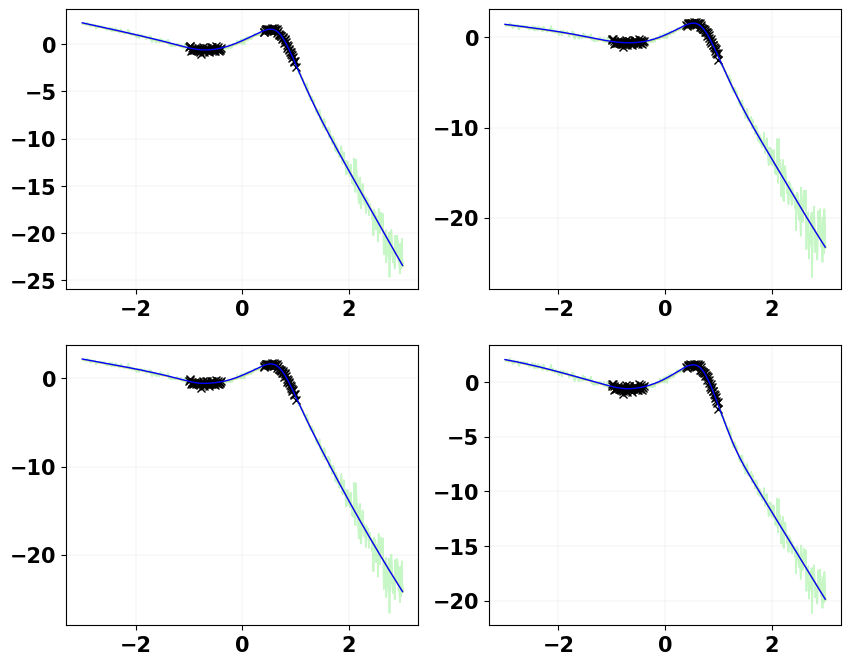

In [204]:
import contextlib
import os
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axs.ravel()):
    e = AutoDeltaVIExperiment(bnn, data, num_samples=1, num_particles=1, num_eval_particles=1)
    with open(os.devnull, "w") as devnull, contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
        e.train(random.PRNGKey(0), num_iter=0)
    e._params = dict(w_auto_loc=map_params['w_auto_loc'][i])
    e.make_predictions(random.PRNGKey(1))
    e.make_plots(fig=fig, ax=ax)
fig.savefig("figs/maps-to-init.png")

In [207]:
experiment = BasicHMCExperiment(
    bnn,
    data,
    num_samples=50, num_warmup=50,
    num_chains=NUM_CHAINS, group_by_chain=True,
    init_params=dict(w=map_params['w_auto_loc']),
)

In [210]:
tqdm_obj = tqdm.tqdm()
start = time.time()
cnt = 0
while time.time() - start <= MAX_TIME:
    experiment.train(random.PRNGKey(1), progress_bar=True)
    with open(f"samples{cnt}.pkl", "wb") as f:
        pickle.dump(experiment._samples, f)
    experiment.make_predictions(random.PRNGKey(1))
    with open(f"preds{cnt}.pkl", "wb") as f:
        pickle.dump(experiment._predictions, f)
    experiment._samples["w"] = jnp.empty((4, 0, bnn.get_weight_dim(),))
    experiment._predictions = None
    info = f"{time.time() - start:.2f} / {MAX_TIME:.2f}"
    tqdm_obj.clear()
    tqdm_obj.display(info)
    cnt += 1

0it [00:00, ?it/s]


sample: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]



MCMC elapsed time: 64.69732785224915


In [ ]:
# with open("hmc-samples-first-half.pkl", "wb") as f:
#     pickle.dump(experiment._samples, f)

In [ ]:
# experiment.make_predictions(random.PRNGKey(1))

In [ ]:
# with open("hmc-preds-first-half.pkl", "wb") as f:
#     pickle.dump(experiment._predictions, f)

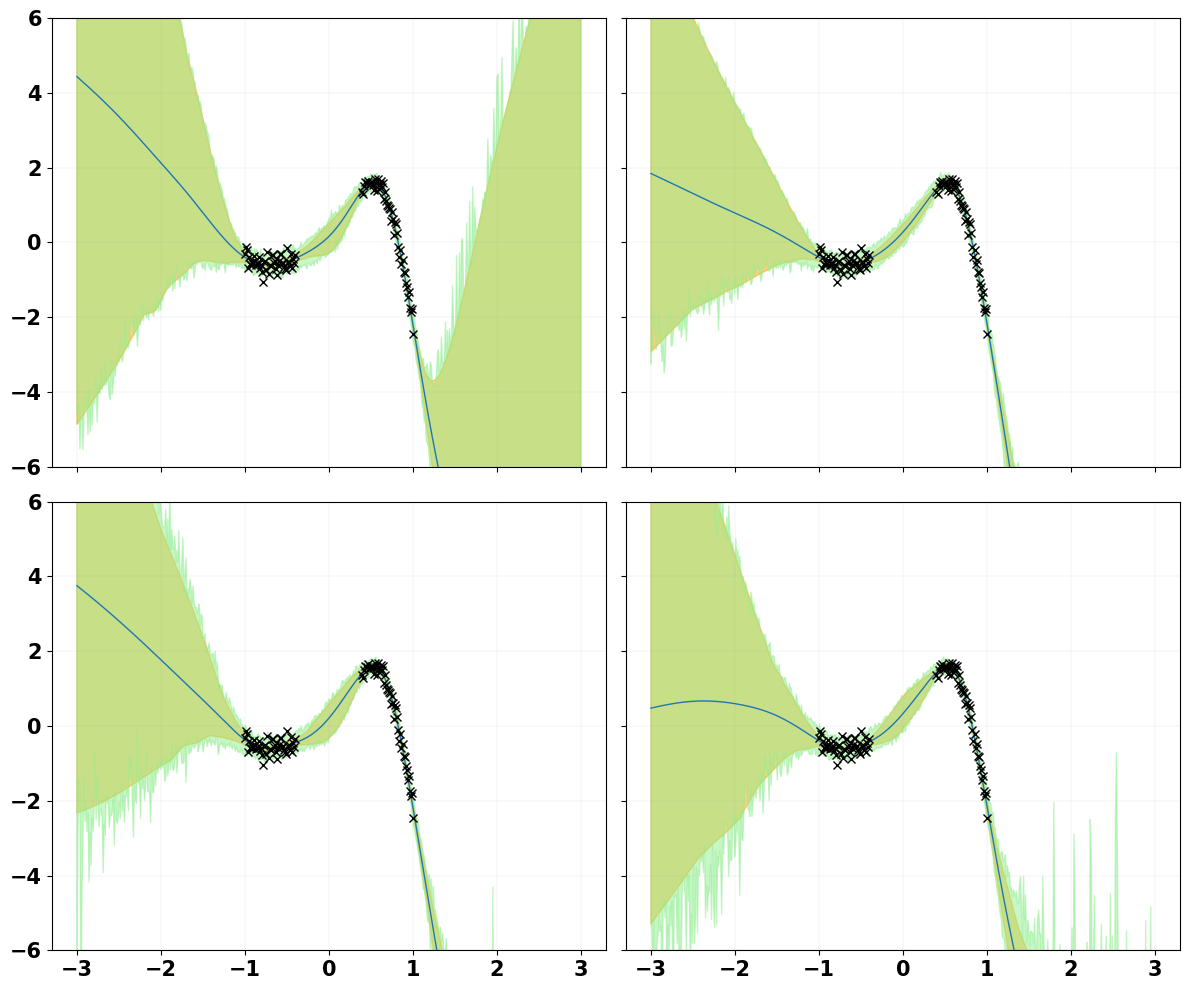

In [211]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex='all', sharey='all')
# for i, ax in enumerate(axs.ravel()):
#     ax.plot(data.test[0][:, 1], experiment._predictions["Y_mean"][..., 0][i].mean(axis=0))
#     ax.fill_between(data.test[0][:, 1],
#                     *np.percentile(experiment._predictions["Y_mean"][..., 0][i], (5.0, 95.0), axis=0), alpha=0.5,
#                     color="orange")
#     ax.fill_between(data.test[0][:, 1], *np.percentile(experiment._predictions["Y"][..., 0][i], (5.0, 95.0), axis=0),
#                     alpha=0.5, color="lightgreen")
#     ax.plot(data.train[0][:, 1], data.train[1], "kx")
#     ax.set_ylim(-6, +6)
# fig.tight_layout()
# fig.savefig("figs/hmc-by-chain.png")